# Assignment 2 - Predicting Survival of Titanic Pasengers

in this mini-project, we are given data of Titanic passengers, and our goal is to train a classifier for predicting whether a passenger survived based on his/her attributes

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# inline plot
% matplotlib inline
# default figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible
np.random.seed(42)
% config Completer.use_jedi = False

first, read the .parquet file using pyarrow and then convert to a pandas DataFrame

In [37]:
import pyarrow.parquet as pq
from pathlib import Path

data_dir_path = Path('..') / 'data'
data_train = pq.read_table(data_dir_path / 'train.parquet', memory_map=True).to_pandas()
data_test = pq.read_table(data_dir_path / 'test.parquet', memory_map=True).to_pandas()

analyze the data by sampling and and different per-column stats

In [3]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios ('William George')",male,NaN,1,1,2661,15.2458,None,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,None,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,None,S
720,721,1,2,"Harper, Miss. Annie Jessie 'Nina'",female,6.0,0,1,248727,33.0000,None,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,None,C


In [4]:
data_test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
20,912,1,"Rothschild, Mr. Martin",male,55.0000,1,0,PC 17603,59.4000,None,C
338,1230,2,"Denbury, Mr. Herbert",male,25.0000,0,0,C.A. 31029,31.5000,None,S
250,1142,2,"West, Miss. Barbara J",female,0.9167,1,2,C.A. 34651,27.7500,None,S
95,987,3,"Tenglin, Mr. Gunnar Isidor",male,25.0000,0,0,350033,7.7958,None,S
162,1054,2,"Wright, Miss. Marion",female,26.0000,0,0,220844,13.5000,None,S


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


so, Name, Sex, Ticket, Cabin and Embarked are non-numerical features. also, Age, Cabin and Embarked seem to have some null values, and we'll deal with them later.

In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


in the train dataset, first of all, there's no Survived feature, so we can't evaluate the performance of a trained model on the train dataset. this probably stems from this problem being a Kaggle competition dataset, and the predictions on the test set are meant for the competition. we'll show our predictions on the train set in the end, in any way.
also, here the columns with missing values are Age, Fare and Cabin, and we'll need to deal with them as well, in a similar way to the train dataset.

In [7]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


the train set is slightly imbalanced, with 38 percent of the train samples tagged as deceased (survived=0)

In [9]:
data_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


seems like a good time to start visualizing the dependence of survival outcome on different features

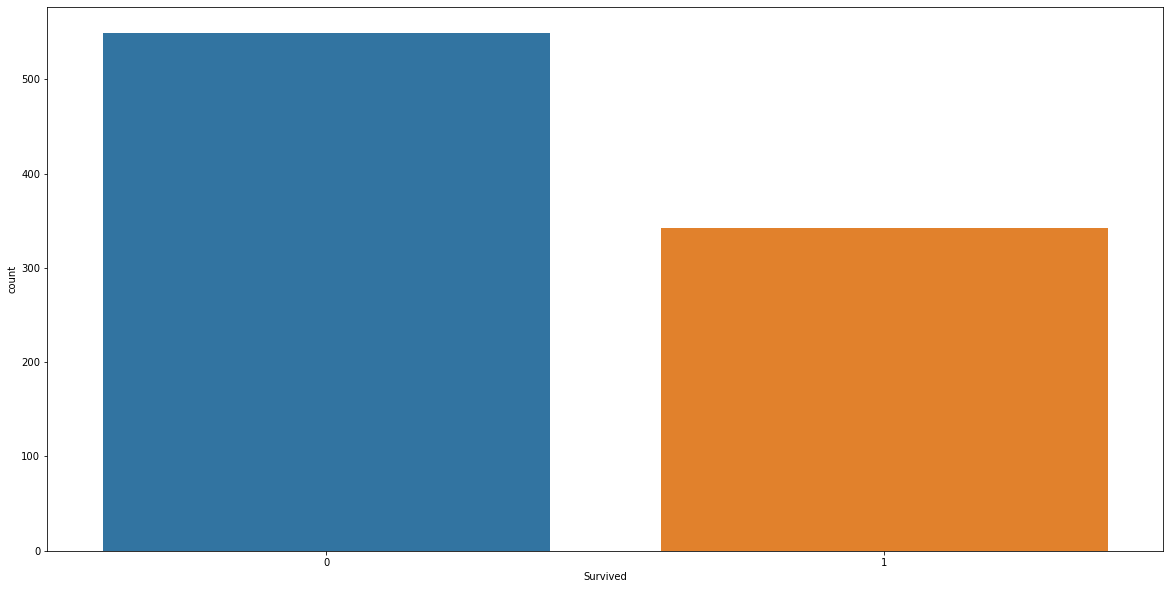

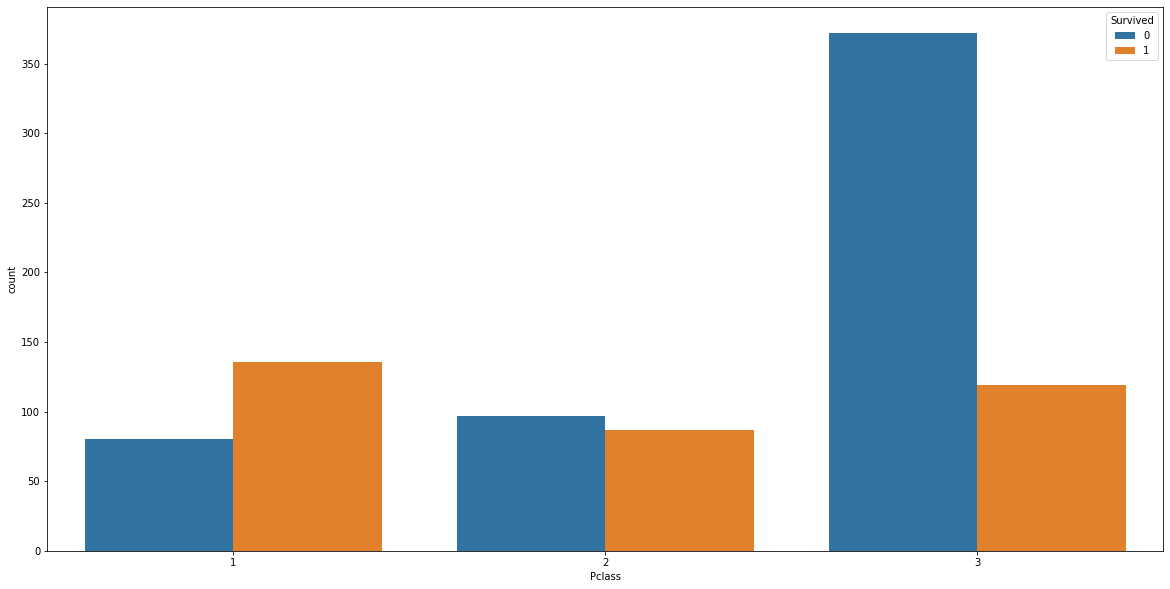

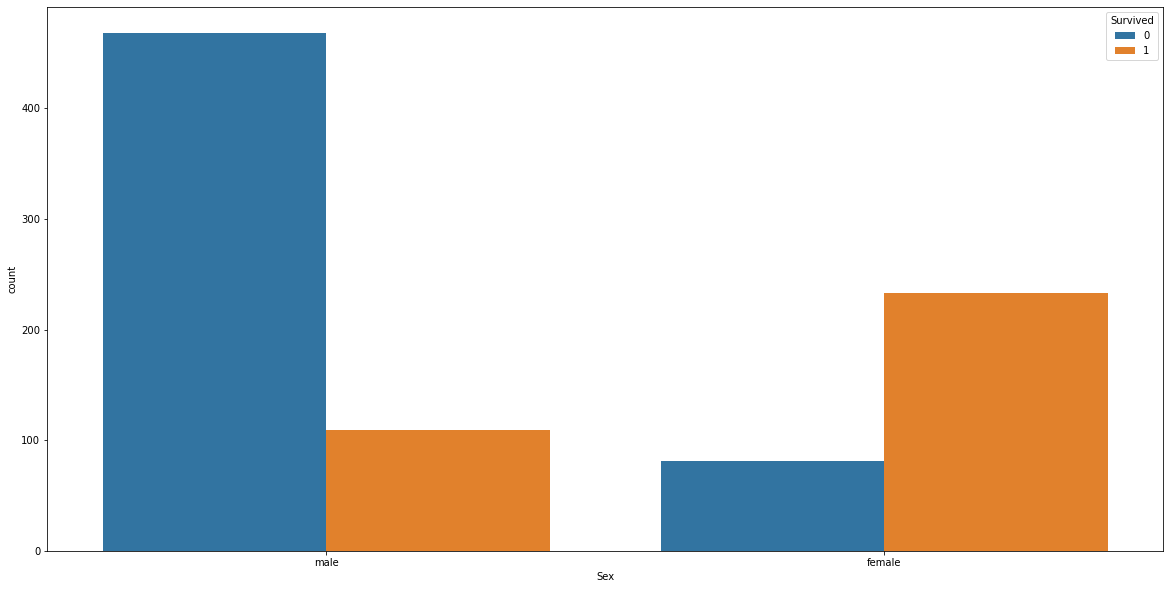

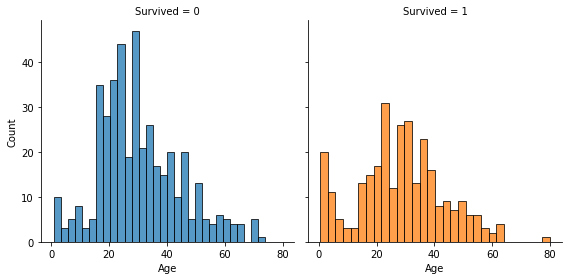

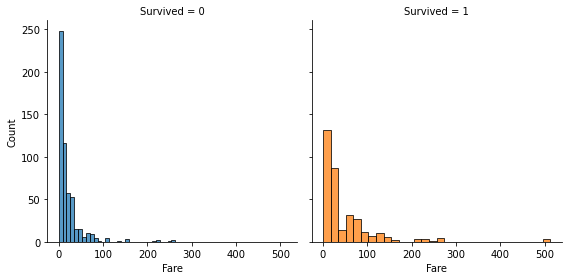

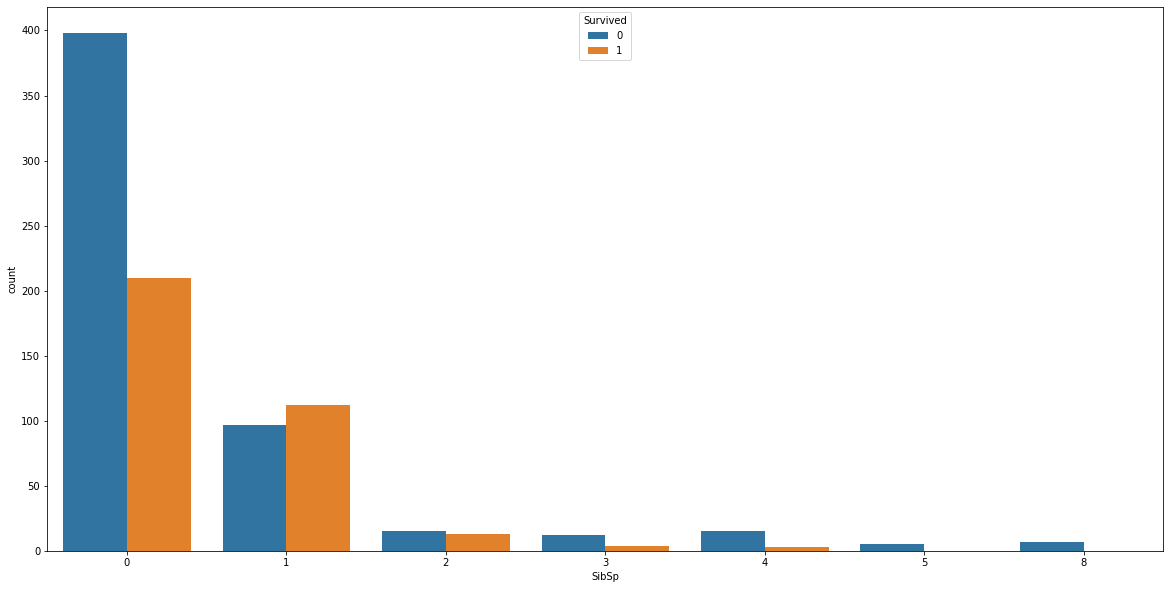

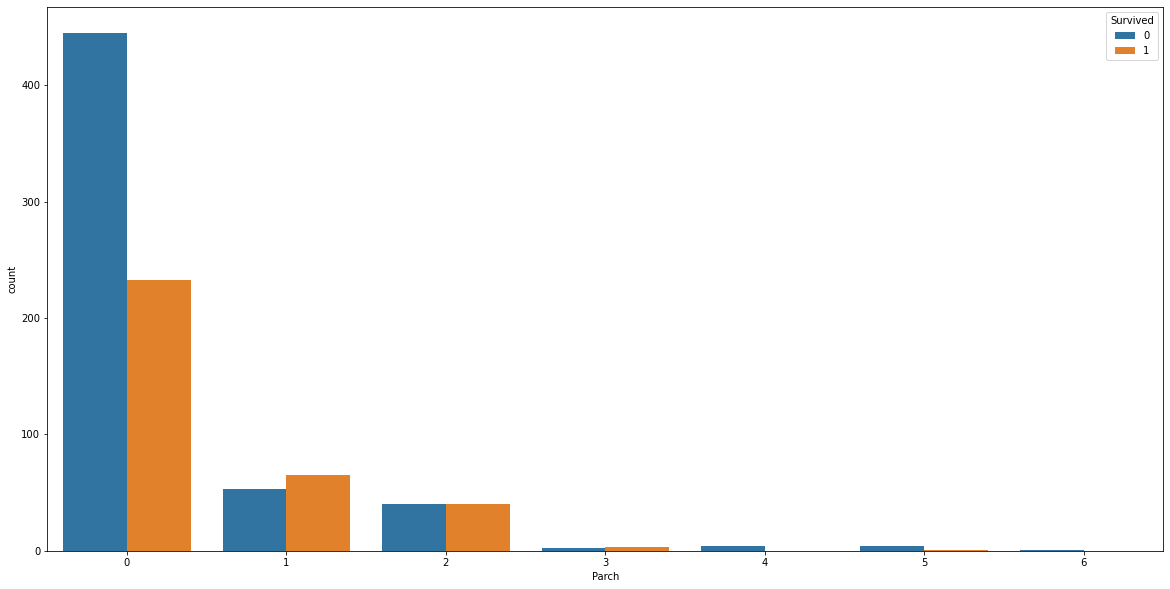

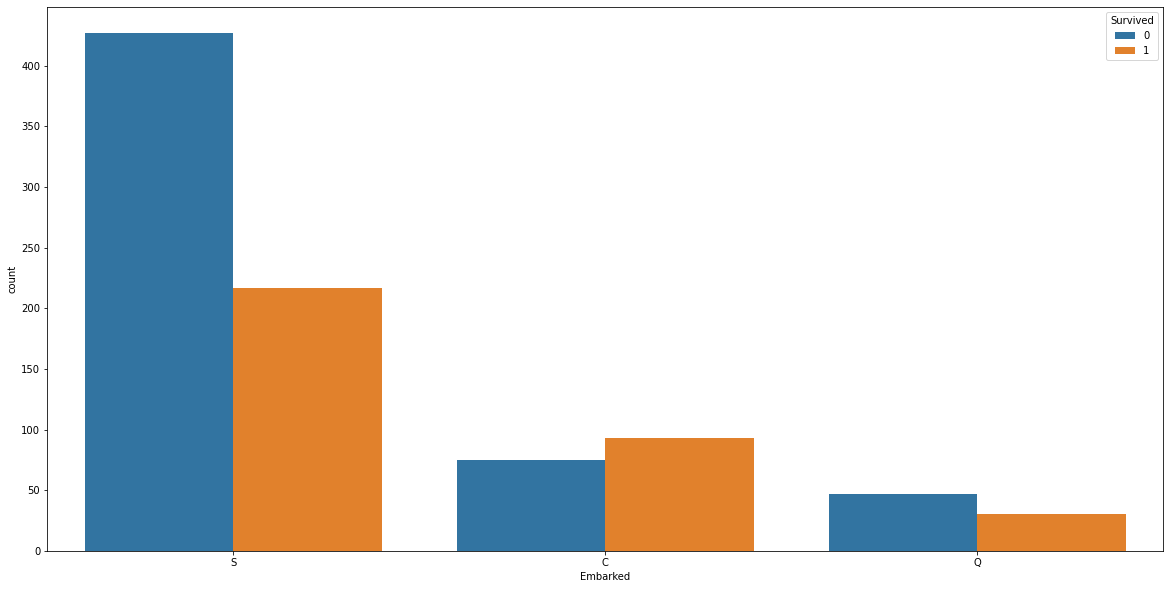

In [12]:
import seaborn as sns

sns.countplot(x='Survived', data=data_train)
plt.show()

sns.countplot(x='Pclass', hue='Survived', data=data_train)
plt.show()

sns.countplot(x='Sex', hue='Survived', data=data_train)
plt.show()

fig = sns.FacetGrid(data_train, col='Survived', hue='Survived', height=4)
fig.map(sns.histplot, 'Age', bins=30, kde=False)
plt.show()

fig = sns.FacetGrid(data_train, col='Survived', hue='Survived', height=4)
fig.map(sns.histplot, 'Fare', bins=30, kde=False)
plt.show()

sns.countplot(x='SibSp', hue='Survived', data=data_train)
plt.show()

sns.countplot(x='Parch', hue='Survived', data=data_train)
plt.legend(title='Survived', loc='upper right')
plt.show()

sns.countplot(x='Embarked', hue='Survived', data=data_train)
plt.show()

a few conclusions we can draw from the plots:
1. the tran dataset contains information about more non-survived passengers (approximately, 60 to 40).
2. in the 1st class - most of the passengers survived. in the 2nd class it is pretty equal chance. but, in the 3rd class a passenger had a small chance of surviving. this seems like a sad truth.
3. women were better in surviving, both in absolute and in relative numbers.
4. most of the surviving passengers are either infants, or somewhere in the 20-40 range. most of the non-surviving are somewhere in the 15-35 range. this agrees with the stats on the Age column that most of the passengers are in the range 15-40 anyway.
5. most of the deceased (not survived) bought really cheap tickets. the same can be said about the majority of the survived, but, some expensive tickets buyers survived as well, while seems like none of them didn't survive. again, this is a truth, though a sad one.
6. SibSp and Parch seem to have a pretty similar effect on survival, so, it might be logical to count them together.
7. port S is a bad place to start if you want to survive. Q is somewhat balanced, while C has more survived passengers.

seems like a good time to remove the Cabin column, that has A LOT of missing values, and the PassengerID and Ticket columns that are irrelevant to the classification problem.

In [38]:
datasets = [data_train, data_test]
for dataset in datasets:
    dataset.drop(columns=['Cabin', 'PassengerId', 'Ticket'], inplace=True, errors='ignore')

more feature engineering, including dealing with missing data and grouping some feature into categories, like Age ranges

In [39]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder


def categorical_to_numerical_column(dataset, column):
    ordinal_encoder = OrdinalEncoder()
    return ordinal_encoder.fit_transform(dataset[[column]]).astype(int)


def impute_mean(dataset, column):
    mean_val = dataset[column].mean()
    dataset[column].fillna(mean_val, inplace=True)


def impute_most_common(dataset, column):
    most_common_val = dataset[column].mode()[0]
    dataset[column].fillna(most_common_val, inplace=True)


def impute_by_normal_dist(dataset, column):
    mean = dataset[column].mean()
    std = dataset[column].std()
    # random normal generator for missing values
    num_of_missing_vals = dataset[column].isnull().sum()
    missing_vals = np.random.normal(mean, std, size=num_of_missing_vals).clip(min=0)
    # fill the missing values
    dataset[column].loc[dataset[column].isnull()] = missing_vals


def group_numerical_column_to_numerical_categories(dataset, column, bins):
    bins = [-1] + bins + [dataset[column].max()]
    return pd.cut(dataset[column], bins=bins, labels=list(range(len(bins) - 1)))

train set missing data

In [40]:
impute_most_common(data_train, 'Embarked')
impute_by_normal_dist(data_train, 'Age')

/opt/miniconda3/envs/orly_hw/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


test set missing data

In [41]:
impute_mean(data_test, 'Fare')
impute_by_normal_dist(data_test, 'Age')

/opt/miniconda3/envs/orly_hw/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


combine Parch and SibSp to a new feature Parch_SibSp, and then add one more: Fare_per_Person

In [42]:
for dataset in datasets:
    dataset['Parch_SibSp'] = dataset['Parch'] + dataset['SibSp']
    dataset['Fare_per_Person'] = (dataset['Fare'] / (dataset['Parch_SibSp'] + 1)).astype(int)

categorical to numerical features

In [43]:
for dataset in datasets:
    for name_column in ['Embarked', 'Sex']:
        dataset[name_column] = categorical_to_numerical_column(dataset, name_column)

group numerical columns to numerical categories

In [44]:
bins_per_col = {'Age': [17, 22, 28, 35, 48], 'Fare': [8, 15, 31, 100]}
for dataset in datasets:
    for name_column in ['Age', 'Fare']:
        dataset[name_column] = group_numerical_column_to_numerical_categories(dataset, name_column,
                                                                              bins_per_col[name_column])

clean the name feature to include only the title part, and group it

In [45]:
name_column = 'Name'
for dataset in datasets:
    cleaned_names = dataset[name_column].str.extract(', ([A-Za-z ]+)\.', expand=False)
    cleaned_names_counts = cleaned_names.value_counts().to_dict()
    dictionary = {t: t for t, c in cleaned_names_counts.items() if c >= 40}
    dictionary |= {t: 'Other' for t, c in cleaned_names_counts.items() if c < 40}
    dictionary |= {'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Miss', 'Mme': 'Mrs', 'Don': 'Master'}

    dataset[name_column] = cleaned_names.map(dictionary)
    dataset[name_column] = categorical_to_numerical_column(dataset, name_column)

now that both the train and the test set are cleaned and engineered, probably that's a good time to start training our classifiers

In [49]:
x_train = data_train.drop(columns=['Survived'])
y_train = data_train['Survived']

we will be comparing four different classifiers:
1. perceptron
2. decision tree
3. bagging
4. random forests

In [60]:
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

#######################
#    Perceptron       #
#######################
# Define
perceptron_clf = Perceptron(max_iter=25)
# train
perceptron_clf.fit(x_train, y_train)
# predict on training data
print(f'Perceptron Classifier train precision {perceptron_clf.score(x_train, y_train)}')

#######################
#    Decision tree    #
#######################
# Define
tree_clf = DecisionTreeClassifier(random_state=42)
# train
tree_clf.fit(x_train, y_train)
# predict on training data
print(f'Decision Tree train precision {tree_clf.score(x_train, y_train)}')

#######################
# Bagging Classifier  #
#######################
# Define
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),  # week learner
    n_estimators=500,  # number of learners to train
    max_samples=100,  # The number of samples to draw from X to train each base estimator
    bootstrap=True,  # Whether features are drawn with replacement
    random_state=42,  # so we can replicate the results,
    oob_score=True  # Whether to use out-of-bag samples to estimate the generalization error
)
# train
bag_clf.fit(x_train, y_train)
# predict on training data
print(f'Bagging Classifier train precision {bag_clf.score(x_train, y_train)}')
print(f'''OOB score {bag_clf.oob_score_}''')

###################
#  Random Forest  #
###################
# Define
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# train
forest_clf.fit(x_train, y_train)
# predict on training data
print(f'Random Forest train precision {forest_clf.score(x_train, y_train)}')

Perceptron Classifier train precision 0.7676767676767676
Decision Tree train precision 0.9337822671156004
Bagging Classifier train precision 0.8630751964085297
OOB score 0.8305274971941639
Random Forest train precision 0.9337822671156004


cross-validation

In [64]:
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


for estimator in [perceptron_clf, tree_clf, bag_clf, forest_clf]:
    # returns an array of scores of the estimator for each run of the cross validation.
    scores = cross_val_score(estimator=estimator, X=x_train, y=y_train,
                             scoring="accuracy", cv=10)
    model_type = estimator.__class__.__name__
    print(f'model type: {model_type}')
    print('=========================')
    display_scores(scores)
    print('-------------------------')

model type: Perceptron
Scores: [0.61111111 0.68539326 0.73033708 0.82022472 0.74157303 0.70786517
 0.7752809  0.73033708 0.66292135 0.60674157]
Mean: 0.7071785268414482
Standard deviation: 0.06436092845106459
-------------------------
model type: DecisionTreeClassifier
Scores: [0.76666667 0.79775281 0.7752809  0.82022472 0.85393258 0.76404494
 0.83146067 0.78651685 0.8988764  0.84269663]
Mean: 0.8137453183520599
Standard deviation: 0.041496386474930445
-------------------------
model type: BaggingClassifier
Scores: [0.78888889 0.86516854 0.75280899 0.85393258 0.83146067 0.83146067
 0.86516854 0.76404494 0.8988764  0.84269663]
Mean: 0.829450686641698
Standard deviation: 0.04466707869375154
-------------------------
model type: RandomForestClassifier
Scores: [0.72222222 0.83146067 0.75280899 0.83146067 0.85393258 0.82022472
 0.85393258 0.74157303 0.85393258 0.82022472]
Mean: 0.8081772784019975
Standard deviation: 0.04748178948534011
-------------------------


seems like decision trees with bagging have the best performance

we turn to hyperparameyter optimization for the bagging classifier

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'base_estimator__max_depth': [1, 2, 3, 4, 5],
    'max_samples': [0.05, 0.1, 0.2, 0.5, 10, 100]
}

clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators=500, max_features=0.5),
                   param_grid, scoring='accuracy')
clf.fit(x_train, y_train)

print(f'''
best params: {clf.best_params_}
best estimator: {clf.best_estimator_}
''')


best params: {'base_estimator__max_depth': 4, 'max_samples': 0.5}
best estimator: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                  max_features=0.5, max_samples=0.5, n_estimators=500)



we should check this "best" classifier against the unoptimized bagging

In [72]:
opt_bag_clf = clf.best_estimator_
for estimator in [bag_clf, opt_bag_clf]:
    # returns an array of scores of the estimator for each run of the cross validation.
    scores = cross_val_score(estimator=estimator, X=x_train, y=y_train,
                             scoring="accuracy", cv=10)
    model_type = estimator.__class__.__name__
    print(f'model type: {model_type}')
    print('=========================')
    display_scores(scores)
    print('-------------------------')

model type: BaggingClassifier
Scores: [0.78888889 0.86516854 0.75280899 0.85393258 0.83146067 0.83146067
 0.86516854 0.76404494 0.8988764  0.84269663]
Mean: 0.829450686641698
Standard deviation: 0.04466707869375154
-------------------------
model type: BaggingClassifier
Scores: [0.83333333 0.86516854 0.76404494 0.88764045 0.84269663 0.82022472
 0.83146067 0.7752809  0.86516854 0.82022472]
Mean: 0.8305243445692885
Standard deviation: 0.036746612260229204
-------------------------


so it seems like a little more robust classifier in terms of standard deviation, and a slightly higher accuracy. probably could play more with the search parameters

now, it is time to measure the success of the different classifiers with more metrics we learned in class, in addition to the cross-validation we've done earlier

confusion matrix, precision, recall, f1

In [77]:
# The data is split according to the cv parameter.
# Each sample belongs to exactly one test set, and its prediction is computed
# with an estimator fitted on the corresponding training set.
# Try not to use - only for the sake of example!!!
from sklearn.model_selection import cross_val_predict

for estimator in [perceptron_clf, tree_clf, bag_clf, forest_clf, opt_bag_clf]:
    y_predictions = cross_val_predict(estimator, x_train, y_train, cv=3, method="predict")
    model_type = estimator.__class__.__name__
    print(f'model type: {model_type}')
    print('=========================')
    from sklearn.metrics import confusion_matrix
    # Explicit way to calculate 'macro'
    cm = confusion_matrix(y_train, y_predictions)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    f1 = 2 * recall * precision / (recall + precision)
    print(f"""
    recall: {np.mean(recall)}
    precision: {np.mean(precision)}
    f1: {np.mean(f1)}
    """)
    print(cm)
    print('-------------------------')

model type: Perceptron

    recall: 0.6086904419518743
    precision: 0.6028241043986496
    f1: 0.5973123001971219
    
[[320 229]
 [125 217]]
-------------------------
model type: DecisionTreeClassifier

    recall: 0.7796472054453072
    precision: 0.7902262953668594
    f1: 0.7839444041805238
    
[[474  75]
 [104 238]]
-------------------------
model type: BaggingClassifier

    recall: 0.8080960598216853
    precision: 0.8262690355329949
    f1: 0.8149532710280374
    
[[494  55]
 [ 97 245]]
-------------------------
model type: RandomForestClassifier

    recall: 0.7895216182532835
    precision: 0.7962979113068505
    f1: 0.7924852417525461
    
[[472  77]
 [ 96 246]]
-------------------------
model type: BaggingClassifier

    recall: 0.8039018310804333
    precision: 0.8207816593395474
    f1: 0.810340687050399
    
[[491  58]
 [ 98 244]]
-------------------------


indeed, the optimized bagging classifier seems the best in terms of performance

precision recall tradeoff & ROC curve

In [93]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([min(thresholds), max(thresholds), 0, 1])             # Not shown

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

model type: DecisionTreeClassifier
recall for 0.9 precision: 0.9093567251461988


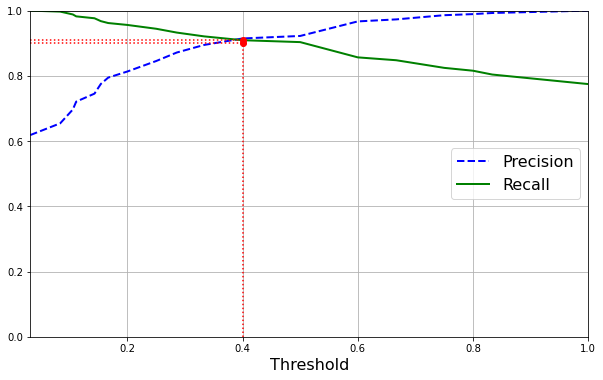

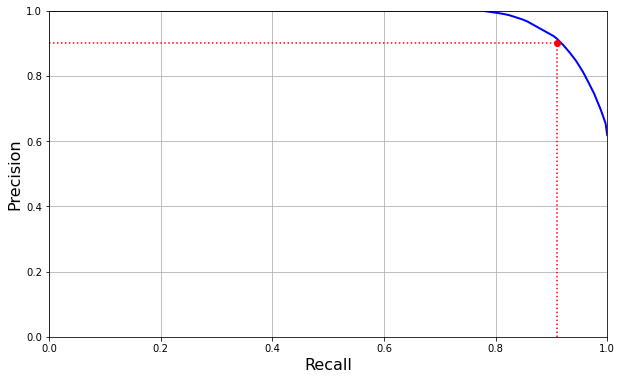

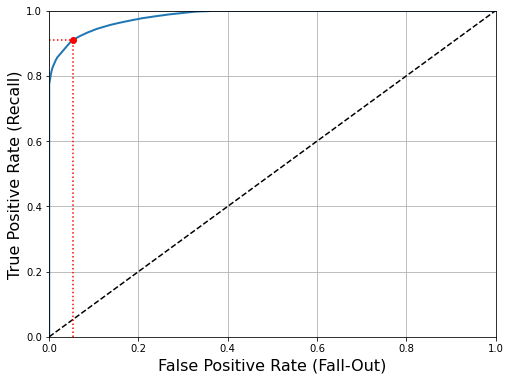

model type: BaggingClassifier
recall for 0.9 precision: 0.6988304093567251


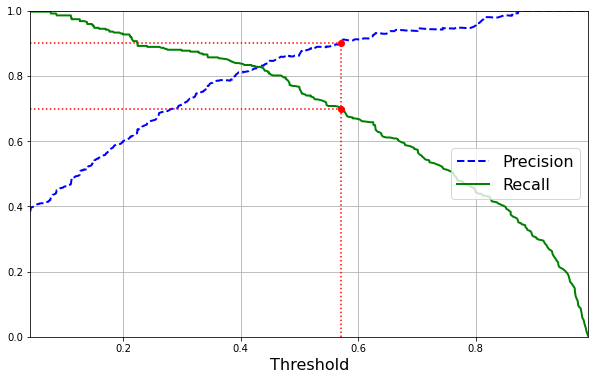

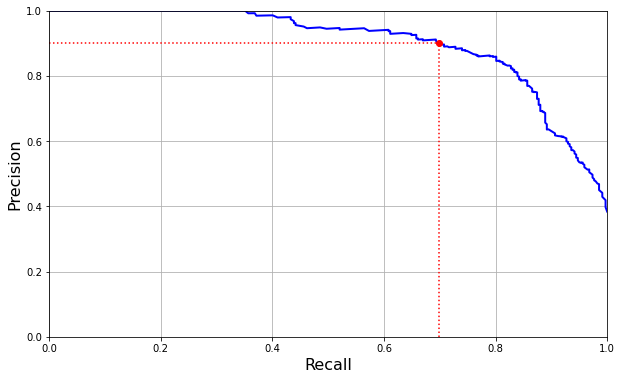

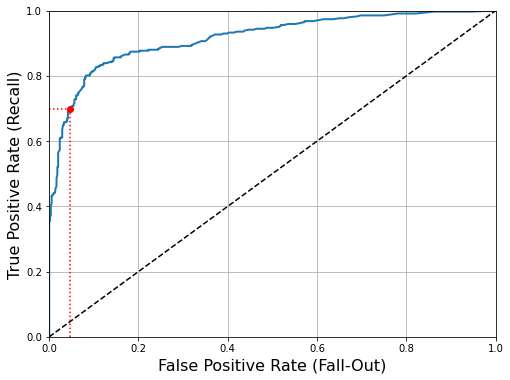

model type: RandomForestClassifier
recall for 0.9 precision: 0.9064327485380117


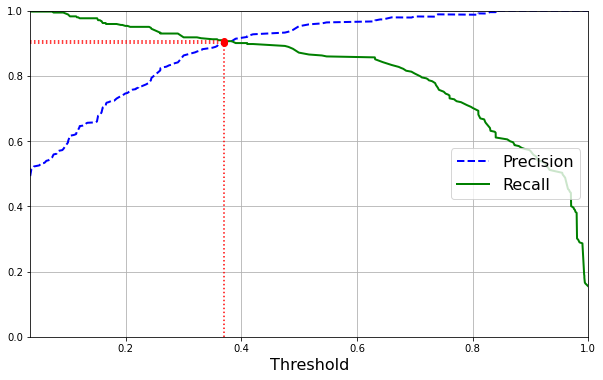

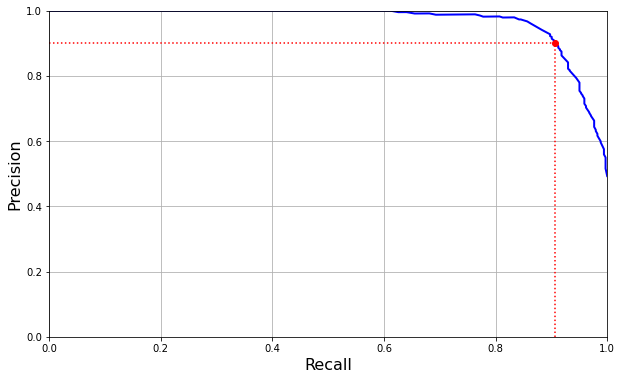

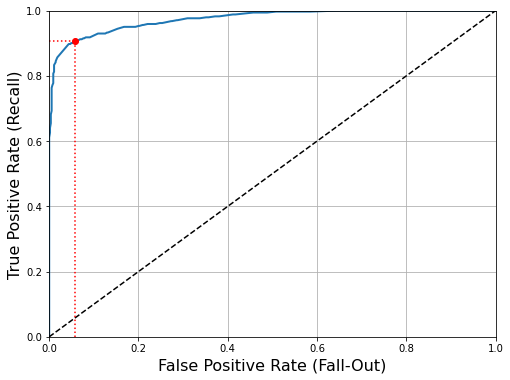

model type: BaggingClassifier
recall for 0.9 precision: 0.6754385964912281


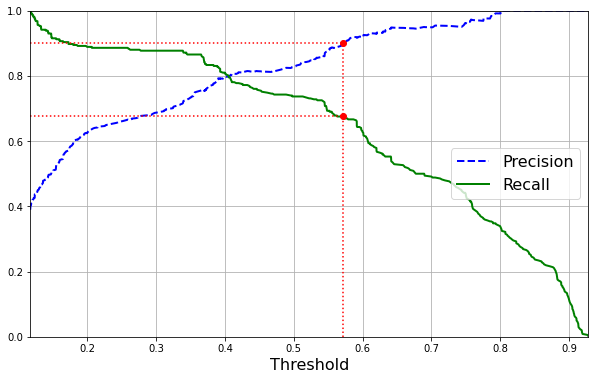

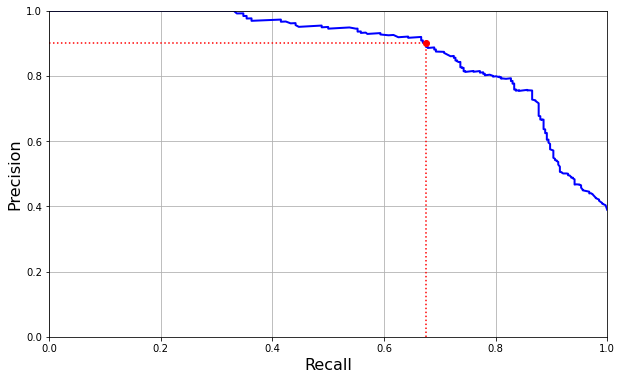

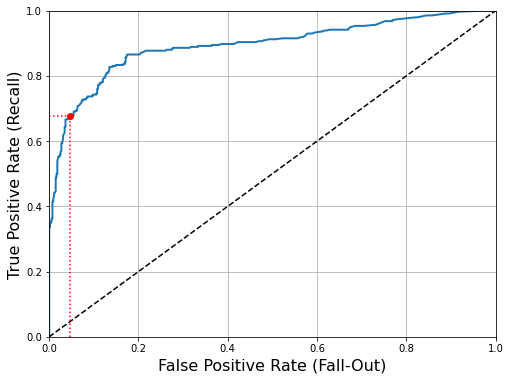

In [94]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

for estimator in [tree_clf, bag_clf, forest_clf, opt_bag_clf]:
    y_scores = estimator.predict_proba(x_train)[:,1]
    # thresholds = thresholds used to obtain each precision recall score
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_train, probas_pred=y_scores)

    model_type = estimator.__class__.__name__
    print(f'model type: {model_type}')

    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(f'recall for 0.9 precision: {recall_90_precision}')
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


    plt.figure(figsize=(10, 6))
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    # plot the recall for the 0.9 precision
    plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
    plt.plot([min(thresholds), threshold_90_precision], [0.9, 0.9], "r:")
    plt.plot([min(thresholds), threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([threshold_90_precision], [0.9], "ro")
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")

    plt.figure(figsize=(10, 6))
    plot_precision_vs_recall(precisions, recalls)
    # this is called recall@precision90
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")

    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    plt.show()

finally, we provide classification results for the test set using the optimized bagging method

In [95]:
test_pred = opt_bag_clf.predict(data_test)
test_pred

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,